In [0]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install tensorflow
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession

MAX_MEMORY = "10g"

spark = SparkSession \
    .builder \
    .appName("Foo") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

# spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_home = os.environ.get('SPARK_HOME', None)

#Get Data
!wget "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [138 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/machine-learning/r

**Importing Required Libraries**

In [0]:
from pyspark import SparkContext
sc = spark.sparkContext

import os
import numpy as np
import pandas as pd
import _pickle as cPickle
import sys
import operator
import json

from pyspark import SparkConf, SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest, DecisionTreeModel
from pyspark.mllib.classification import SVMWithSGD
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import os
import sys
import tarfile
import pickle
import cv2
import matplotlib.pyplot as plt
import random
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
%matplotlib inline

**Extracting the Dataset**

In [0]:
#Extracting Dataset
data_root = '.'

def _extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()

dataset = os.path.join(data_root, 'cifar-100-python.tar.gz')

_extract(dataset)

Extracting data for ./cifar-100-python.


**Loading the extracted dataset and printing the both the labels (course labels and fine labels)**

In [0]:
#  load a pickle file
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


# load train, test, and meta
train_dec = unpickle('./cifar-100-python/train')
test_dec = unpickle('./cifar-100-python/test')
meta = unpickle('./cifar-100-python/meta')


#printing values of meta file 
fine_labels = [x.decode('utf-8') for x in meta.get(b'fine_label_names')]
print('Fine Labels :', fine_labels)
coarse_labels = [x.decode('utf-8') for x in meta.get(b'coarse_label_names')]
print('Coarse Labels :', coarse_labels)

Fine Labels : ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 

**Combining the train data and test data.**

In [0]:
datatrain=sc.parallelize(zip(train_dec[b'data'].tolist(),train_dec[b'coarse_labels'],train_dec[b'fine_labels']))
datatest=sc.parallelize(zip(test_dec[b'data'].tolist(),test_dec[b'coarse_labels'],test_dec[b'fine_labels']))
data = spark.createDataFrame(datatrain.union(datatest)) 
data.count()
data.show(2)

+--------------------+---+---+
|                  _1| _2| _3|
+--------------------+---+---+
|[255, 255, 255, 2...| 11| 19|
|[255, 253, 253, 2...| 15| 29|
+--------------------+---+---+
only showing top 2 rows



**Renaming the columns**

In [0]:
#Renaming the columns
data=data.withColumnRenamed("_1","features").withColumnRenamed("_2","coarse_labels").withColumnRenamed("_3","fine_labels")

**Finding the index of super class Vehicle 1 and Vehicle 2**

In [0]:
#finding index of assigned superclass vehicles_1 and vehicles_2
vehicles1_index = [coarse_labels.index(x) for x in coarse_labels if x == 'vehicles_1']
vehicles2_index = [coarse_labels.index(x) for x in coarse_labels if x == 'vehicles_2']

#printing index
print(vehicles1_index)
print(vehicles2_index)

[18]
[19]


**Filtering the dataset to get Vehicle 1 and Vehicle 2 data**

In [0]:
data=data.filter((data['coarse_labels']==18) | (data['coarse_labels']==19))
data.show(2)

+--------------------+-------------+-----------+
|            features|coarse_labels|fine_labels|
+--------------------+-------------+-----------+
|[50, 56, 52, 50, ...|           18|         90|
|[35, 27, 31, 77, ...|           18|          8|
+--------------------+-------------+-----------+
only showing top 2 rows



**Validating the data by plotting with coarse labels and fine labels**

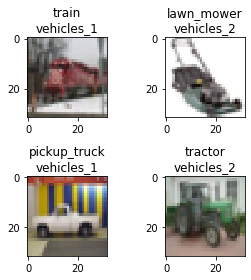

In [0]:
#Taking random data 
sample = data.rdd.takeSample(withReplacement=False,num=4)

# To view sample data
fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
k=1
for i in sample:
    ax = fig.add_subplot(2, 2, k)
    img = np.array(i['features']).reshape(3,32,32).transpose([1, 2, 0])
    fig.set_tight_layout(True) 
    ax=plt.imshow(img)
    a = fine_labels[i['fine_labels']]
    b = coarse_labels[i['coarse_labels']]
    ax=plt.title(a+"\n"+b)
    k=k+1


# ****Preprocessing the data for training models****

**Creating dense vectors and creating 1 and 0 labels**

In [0]:

data = data.rdd.map(lambda x: Row(features=Vectors.dense(x.features), coarse_labels=x.coarse_labels, fine_labels=x.fine_labels)).toDF()
#Divide x[0] by 255 to normalize the data

#Converting labels 18 and 19 to 1 and 0 respectively
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='labelindex')
data = stringindexer.fit(data).transform(data)
data.show(2)

+-------------+--------------------+-----------+----------+
|coarse_labels|            features|fine_labels|labelindex|
+-------------+--------------------+-----------+----------+
|           18|[50.0,56.0,52.0,5...|         90|       1.0|
|           18|[35.0,27.0,31.0,7...|          8|       1.0|
+-------------+--------------------+-----------+----------+
only showing top 2 rows



**Splitting the data into train and test**

In [0]:
#Splitting into train and test
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [0]:
#Random Split does not split with exact proportions
test.count() 

1182

In [0]:
test.printSchema()

root
 |-- coarse_labels: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- labelindex: double (nullable = false)



**Running Random Forest Classifier**

In [0]:
%%time
#Creating an object
rfc=RandomForestClassifier(featuresCol="features", labelCol="labelindex",numTrees=155)
#Fitting Random Forest Classifier to the training data
rfc_model=rfc.fit(train)
#Predicting with test data
rfc_prediction=rfc_model.transform(test)

CPU times: user 63.8 ms, sys: 16 ms, total: 79.9 ms
Wall time: 3min 49s


**Plotting Predicted Images**

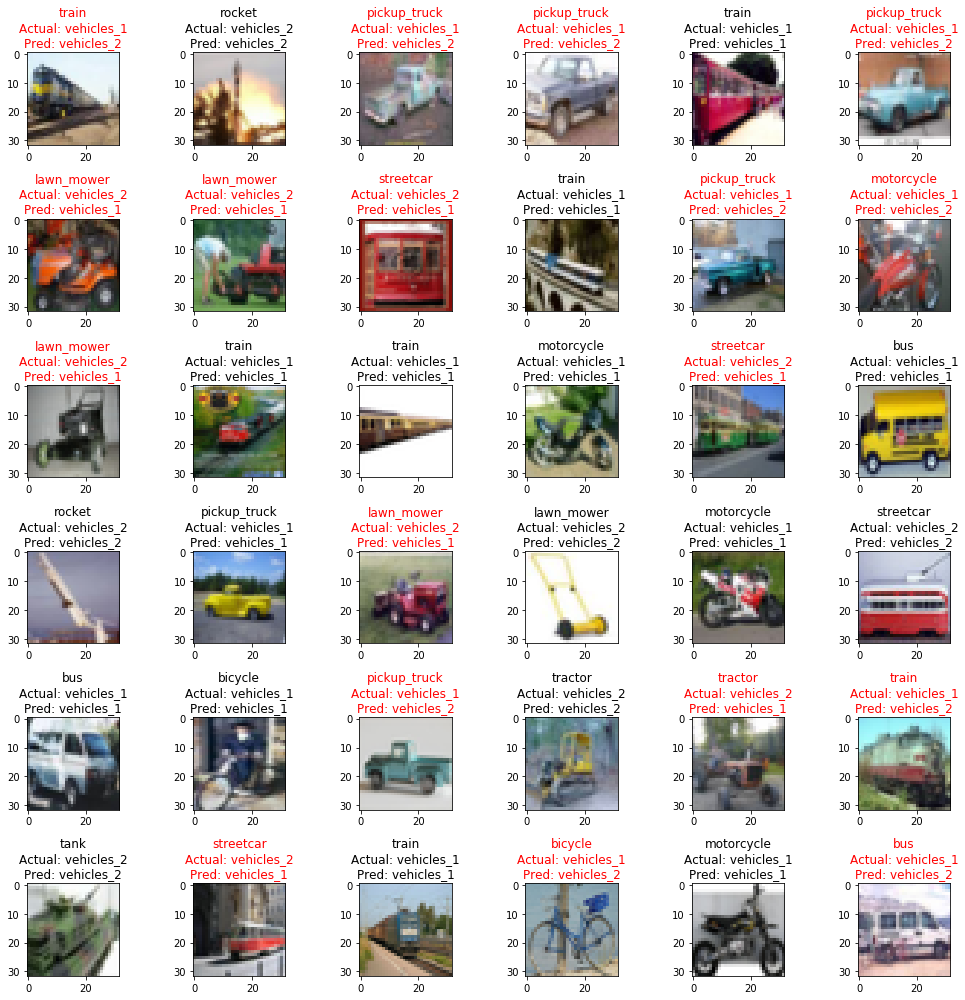

In [0]:
#Taking random data from test data to print predicted images
sample = rfc_prediction.rdd.takeSample(withReplacement=False,num=36)

# To view sample data
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
k=1
for i in sample:
    ax = fig.add_subplot(6, 6, k)
    img = np.array(i['features'].astype(int)).reshape(3,32,32).transpose([1, 2, 0])
    fig.set_tight_layout(True) 
    ax=plt.imshow(img)
    a = fine_labels[i['fine_labels']]
    b = coarse_labels[i['coarse_labels']]
    if i['prediction']==1:
      m=18
    elif i['prediction']==0:
      m=19
    c = coarse_labels[m]
    if i['prediction']== i['labelindex']:
      ax=plt.title(a+"\nActual: "+b +"\nPred: "+c)
    else:
      ax=plt.title(a+"\nActual: "+b +"\nPred: "+c, color = 'red')
    k=k+1

**Confusion Matrix and Classification Report**

In [0]:
rfc_eval=BinaryClassificationEvaluator(labelCol="labelindex")
print("Area Under The Curve: %.3f" % rfc_eval.evaluate(rfc_prediction))


Area Under The Curve: 0.694


In [0]:
conf_mat = rfc_prediction.select('labelindex', 'prediction')
conf_mat.rdd.zipWithIndex().countByKey()

defaultdict(int,
            {Row(labelindex=0.0, prediction=0.0): 315,
             Row(labelindex=0.0, prediction=1.0): 256,
             Row(labelindex=1.0, prediction=0.0): 165,
             Row(labelindex=1.0, prediction=1.0): 446})

In [0]:
predictionRDD = rfc_prediction.select(['labelindex', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)

In [0]:
# Confusion Matrix
cm = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         315         256
real  1         165         446


In [0]:
# Define a function to evaluate each of the two labels, i.e., 0 and 1
def cr(label_in):
  precision = metrics.precision(label=label_in)
  recall = metrics.recall(label=label_in)
  F1_Measure = metrics.fMeasure(label=label_in)
  support = test.filter(test.labelindex==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
          (label_in,precision, recall, F1_Measure, support))

In [0]:
import numpy as np
print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.66          0.55         0.60          571
       1.0         0.64          0.73         0.68          611


In [0]:
# Accuracy
print("Accuracy :  %.3f" %((cm[0][0] + cm[1][1])/(cm[0][0] + cm[1][1]+ cm[0][1]+ cm[1][0])))

Accuracy :  0.644
